In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


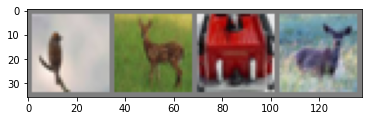

 bird  deer truck  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [108]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [109]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [110]:
def train(epochs):
  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0

  print('Finished Training')

train(2)

[1,  2000] loss: 2.217
[1,  4000] loss: 1.885
[1,  6000] loss: 1.654
[1,  8000] loss: 1.559
[1, 10000] loss: 1.503
[1, 12000] loss: 1.445
[2,  2000] loss: 1.370
[2,  4000] loss: 1.381
[2,  6000] loss: 1.346
[2,  8000] loss: 1.289
[2, 10000] loss: 1.264
[2, 12000] loss: 1.275
Finished Training


In [36]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

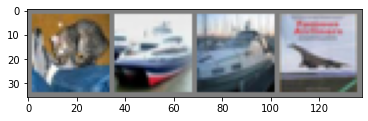

GroundTruth:    cat  ship  ship plane


In [37]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [38]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [39]:
outputs = net(images)

In [40]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  ship  ship


In [47]:
def test():
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          # calculate outputs by running images through the network 
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  
test()

In [111]:
def accuracy_by_class():
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for data in testloader:
          images, labels = data    
          outputs = net(images)    
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

    
  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                    accuracy))
      
accuracy_by_class()

Accuracy for class plane is: 42.8 %
Accuracy for class car   is: 63.0 %
Accuracy for class bird  is: 37.4 %
Accuracy for class cat   is: 30.7 %
Accuracy for class deer  is: 51.4 %
Accuracy for class dog   is: 51.2 %
Accuracy for class frog  is: 65.9 %
Accuracy for class horse is: 58.7 %
Accuracy for class ship  is: 87.0 %
Accuracy for class truck is: 54.6 %


In [146]:
class ThreeLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = (F.relu(self.conv3(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ThreeLayerNet()

In [147]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [148]:
train(2)

[1,  2000] loss: 2.283
[1,  4000] loss: 2.024
[1,  6000] loss: 1.809
[1,  8000] loss: 1.695
[1, 10000] loss: 1.569
[1, 12000] loss: 1.501
[2,  2000] loss: 1.420
[2,  4000] loss: 1.380
[2,  6000] loss: 1.318
[2,  8000] loss: 1.311
[2, 10000] loss: 1.275
[2, 12000] loss: 1.220
Finished Training


In [141]:
test()

Accuracy of the network on the 10000 test images: 54 %


In [142]:
accuracy_by_class()

Accuracy for class plane is: 50.0 %
Accuracy for class car   is: 81.3 %
Accuracy for class bird  is: 36.4 %
Accuracy for class cat   is: 40.8 %
Accuracy for class deer  is: 53.0 %
Accuracy for class dog   is: 39.9 %
Accuracy for class frog  is: 74.0 %
Accuracy for class horse is: 47.3 %
Accuracy for class ship  is: 78.1 %
Accuracy for class truck is: 39.7 %


In [163]:
class FourLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        x = (F.relu(self.conv4(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = FourLayerNet()

In [164]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [165]:
train(2)

[1,  2000] loss: 2.303
[1,  4000] loss: 2.217
[1,  6000] loss: 1.996
[1,  8000] loss: 1.815
[1, 10000] loss: 1.683
[1, 12000] loss: 1.585
[2,  2000] loss: 1.491
[2,  4000] loss: 1.466
[2,  6000] loss: 1.394
[2,  8000] loss: 1.348
[2, 10000] loss: 1.300
[2, 12000] loss: 1.261
Finished Training


In [166]:
test()

Accuracy of the network on the 10000 test images: 56 %


In [167]:
accuracy_by_class()

Accuracy for class plane is: 57.4 %
Accuracy for class car   is: 60.9 %
Accuracy for class bird  is: 40.5 %
Accuracy for class cat   is: 37.5 %
Accuracy for class deer  is: 57.2 %
Accuracy for class dog   is: 35.0 %
Accuracy for class frog  is: 64.7 %
Accuracy for class horse is: 60.1 %
Accuracy for class ship  is: 82.3 %
Accuracy for class truck is: 70.8 %


In [201]:
class CifarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        x = (F.relu(self.conv4(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



net = CifarNet()

In [202]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [203]:
train(2)

[1,  2000] loss: 2.294
[1,  4000] loss: 2.053
[1,  6000] loss: 1.793
[1,  8000] loss: 1.673
[1, 10000] loss: 1.556
[1, 12000] loss: 1.497
[2,  2000] loss: 1.382
[2,  4000] loss: 1.343
[2,  6000] loss: 1.293
[2,  8000] loss: 1.281
[2, 10000] loss: 1.188
[2, 12000] loss: 1.172
Finished Training


In [204]:
test()

Accuracy of the network on the 10000 test images: 60 %


In [205]:
accuracy_by_class()

Accuracy for class plane is: 60.1 %
Accuracy for class car   is: 79.6 %
Accuracy for class bird  is: 45.3 %
Accuracy for class cat   is: 51.6 %
Accuracy for class deer  is: 31.8 %
Accuracy for class dog   is: 50.0 %
Accuracy for class frog  is: 70.9 %
Accuracy for class horse is: 75.5 %
Accuracy for class ship  is: 79.9 %
Accuracy for class truck is: 59.5 %


In [206]:
class ThreeLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = (F.relu(self.conv3(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ThreeLayerNet()

In [207]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [213]:
train(6)

[1,  2000] loss: 0.680
[1,  4000] loss: 0.693
[1,  6000] loss: 0.682
[1,  8000] loss: 0.706
[1, 10000] loss: 0.698
[1, 12000] loss: 0.692
[2,  2000] loss: 0.581
[2,  4000] loss: 0.572
[2,  6000] loss: 0.609
[2,  8000] loss: 0.603
[2, 10000] loss: 0.614
[2, 12000] loss: 0.600
[3,  2000] loss: 0.465
[3,  4000] loss: 0.494
[3,  6000] loss: 0.504
[3,  8000] loss: 0.506
[3, 10000] loss: 0.517
[3, 12000] loss: 0.540
[4,  2000] loss: 0.363
[4,  4000] loss: 0.419
[4,  6000] loss: 0.426
[4,  8000] loss: 0.448
[4, 10000] loss: 0.446
[4, 12000] loss: 0.484
[5,  2000] loss: 0.298
[5,  4000] loss: 0.344
[5,  6000] loss: 0.382
[5,  8000] loss: 0.384
[5, 10000] loss: 0.400
[5, 12000] loss: 0.390
[6,  2000] loss: 0.232
[6,  4000] loss: 0.282
[6,  6000] loss: 0.320
[6,  8000] loss: 0.327
[6, 10000] loss: 0.320
[6, 12000] loss: 0.359
Finished Training


In [214]:
test()

Accuracy of the network on the 10000 test images: 72 %


In [215]:
accuracy_by_class()

Accuracy for class plane is: 78.8 %
Accuracy for class car   is: 80.4 %
Accuracy for class bird  is: 56.5 %
Accuracy for class cat   is: 68.2 %
Accuracy for class deer  is: 68.8 %
Accuracy for class dog   is: 57.5 %
Accuracy for class frog  is: 76.4 %
Accuracy for class horse is: 75.3 %
Accuracy for class ship  is: 77.2 %
Accuracy for class truck is: 83.2 %


In [232]:
class ThreeLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, 5)
        self.conv3 = nn.Conv2d(128, 512, 3)
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = (F.relu(self.conv3(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ThreeLayerNet()

In [233]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [234]:
train(2)

[1,  2000] loss: 2.218
[1,  4000] loss: 1.827
[1,  6000] loss: 1.634
[1,  8000] loss: 1.520
[1, 10000] loss: 1.403
[1, 12000] loss: 1.343
[2,  2000] loss: 1.253
[2,  4000] loss: 1.183
[2,  6000] loss: 1.159
[2,  8000] loss: 1.108
[2, 10000] loss: 1.047
[2, 12000] loss: 1.011
Finished Training


In [235]:
test()

Accuracy of the network on the 10000 test images: 65 %


In [236]:
accuracy_by_class()

Accuracy for class plane is: 75.2 %
Accuracy for class car   is: 87.6 %
Accuracy for class bird  is: 51.7 %
Accuracy for class cat   is: 29.8 %
Accuracy for class deer  is: 55.6 %
Accuracy for class dog   is: 71.2 %
Accuracy for class frog  is: 69.7 %
Accuracy for class horse is: 65.2 %
Accuracy for class ship  is: 76.3 %
Accuracy for class truck is: 70.4 %
